# 📊 Projet MLOps - Prédiction du Risque de Défaut sur les Prêts Personnels

## 💼 Contexte
Le secteur de la banque de détail connaît actuellement des taux de défaut plus élevés que prévu sur les prêts personnels. Les prêts personnels sont une source majeure de revenus, mais ils comportent des risques. L'objectif de ce projet est de développer un algorithme capable de prédire le risque de défaut d'un emprunteur.

## 🎯 Objectif
Construire un modèle de machine learning pour prédire si un client fera défaut sur son prêt, en s'appuyant sur les données historiques fournies par la banque.

## 🧩 Approche MLOps End-to-End
Ce notebook suit une approche MLOps complète, en passant par les étapes suivantes :
1. Compréhension du problème
2. Préparation et analyse des données
3. Modélisation avec plusieurs algorithmes
4. Évaluation des performances
5. Sauvegarde du modèle pour un futur déploiement

---

## 🔍 Jeu de données
Nom du fichier : `Loan_Data.csv`

Ce fichier contient des informations sur les prêts octroyés, les caractéristiques des emprunteurs, et s'ils ont fait défaut ou non.


# Modèle de prédiction de défaut de prêts

Ce notebook a pour objectif de construire un modèle de **prédiction de défaut** 
sur un portefeuille de prêts, en utilisant le fichier `Loan_Data.csv`.

Nous allons suivre une démarche étape par étape :
1. Compréhension du jeu de données
2. Pré-traitement et préparation des variables
3. Entraînement de plusieurs modèles de classification
4. Évaluation et calibration
5. Sauvegarde du meilleur modèle pour un futur déploiement (Streamlit / Flask)

---


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Librairies de machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    confusion_matrix, classification_report,
    RocCurveDisplay, PrecisionRecallDisplay
)
import mlflow
import mlflow.sklearn


## 2-  Exploration des données (EDA)

Dans cette section, nous allons explorer le fichier `Loan_Data.csv` afin de :
- Vérifier la structure et les colonnes disponibles
- Contrôler les types de variables et valeurs manquantes
- Examiner la distribution de la variable cible `default`
- Obtenir des statistiques descriptives des variables numériques


### 2.1 Chargement et aperçu du jeu de données

In [2]:
# Chargement des données 

# Définition du chemin d'accès au fichier de données
DATA_PATH = "Data/Loan_Data.csv"

# Chargement des données à partir du fichier CSV 
df = pd.read_csv(DATA_PATH)

# # Affichage des 5 premières lignes du DataFrame pour avoir un aperçu des données
df.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


### 2.2 Informations générales sur le dataset

Dans cette partie, nous allons examiner :

- Les **dimensions** du dataset (nombre de lignes et de colonnes)  
- La **liste des colonnes** disponibles  
- Les **types de données** (int, float, object, etc.)  
- Un **résumé global** des variables (`df.info()`)  
- Le **nombre de valeurs manquantes** par colonne  
- La **distribution de la variable cible** `default`


In [3]:
# Affichage des noms de toutes les colonnes présentes dans le DataFrame
print("Nom des colonnes disponibles:", df.columns.tolist())

# Dimensions (nb de lignes et nb de colonnes)
print(f"Nombre de lignes : {df.shape[0]}")
print(f"Nombre de colonnes : {df.shape[1]}")

# Affichage du type de données (int, float, object, etc.) pour chaque colonne
print("\nTypes de données :")
print(df.dtypes)

# Affichage d’un résumé des informations du DataFrame :
# nombre total de lignes, de colonnes, types de données, non-null counts, etc.
print("\nInformations générales sur les variables :")
print(df.info())

# Affichage du nombre de valeurs manquantes par colonne
print("\nValeurs manquantes par colonne :")
print(df.isnull().sum())  

# Affichage de la distribution de la variable cible "default"
# La distribution est normalisée (en pourcentage)
print("\nDistribution de la variable cible 'default' :")
print(df["default"].value_counts(normalize=True))

Nom des colonnes disponibles: ['customer_id', 'credit_lines_outstanding', 'loan_amt_outstanding', 'total_debt_outstanding', 'income', 'years_employed', 'fico_score', 'default']
Nombre de lignes : 10000
Nombre de colonnes : 8

Types de données :
customer_id                   int64
credit_lines_outstanding      int64
loan_amt_outstanding        float64
total_debt_outstanding      float64
income                      float64
years_employed                int64
fico_score                    int64
default                       int64
dtype: object

Informations générales sur les variables :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10000 non-null  int64  
 1   credit_lines_outstanding  10000 non-null  int64  
 2   loan_amt_outstanding      10000 non-null  float64
 3   total_debt_outstanding

### 2.2 bis Nettoyage des colonnes non pertinentes
Nous retirons la colonne `customer_id`, qui est un identifiant non prédictif.  
Nous créons un nouveau DataFrame `df_model` identique à `df` mais sans cette colonne.  
Toutes les étapes suivantes (statistiques, visualisations, modélisation) utiliseront `df_model`.


In [4]:
TARGET = "default"
ID_COLS = ["customer_id"]

# DataFrame pour la modélisation (sans l'ID)
df_model = df.drop(columns=ID_COLS).copy()

### 2.3 Statistiques descriptives

Dans cette section, nous allons examiner des **statistiques descriptives** sur les variables numériques :  
- Moyenne, écart-type  
- Minimum et maximum  
- Quartiles (25%, 50%, 75%)  

Cela permet de détecter rapidement d’éventuelles anomalies ou valeurs extrêmes dans les données.


In [5]:
print("Résumé statistique des variables numériques :")
df_model.describe().T


Résumé statistique des variables numériques :


,count,mean,std,min,25%,50%,75%,max
credit_lines_outstanding,10000.0,1.461200,1.743846,0.000000,0.000000,1.000000,2.000000,5.00000
loan_amt_outstanding,10000.0,4159.677034,1421.399078,46.783973,3154.235371,4052.377228,5052.898103,10750.67781
total_debt_outstanding,10000.0,8718.916797,6627.164762,31.652732,4199.836020,6732.407217,11272.263740,43688.78410
income,10000.0,70039.901401,20072.214143,1000.000000,56539.867903,70085.826330,83429.166133,148412.18050
years_employed,10000.0,4.552800,1.566862,0.000000,3.000000,5.000000,6.000000,10.00000
fico_score,10000.0,637.557700,60.657906,408.000000,597.000000,638.000000,679.000000,850.00000
default,10000.0,0.185100,0.388398,0.000000,0.000000,0.000000,0.000000,1.00000


### 2.4 Visualisation des distributions

Dans cette partie, nous allons visualiser :
- La **distribution de la variable cible** `default` (histogramme / barplot)
- Les **distributions des variables numériques** (histogrammes)
- Éventuellement la **corrélation entre les variables** sous forme de heatmap

Ces graphiques aident à mieux comprendre la répartition des données et à repérer d’éventuels déséquilibres ou valeurs atypiques.


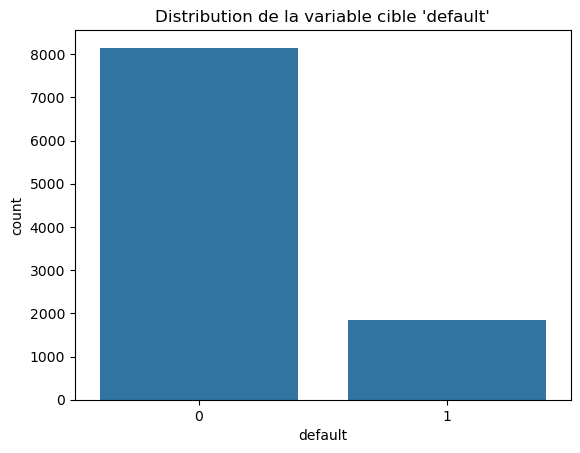

In [6]:
# --- 2.4.1 Visualisation de la distribution de la cible ---

import seaborn as sns
import matplotlib.pyplot as plt

# On utilise df_model (df sans 'customer_id') pour toutes les analyses/modélisation
# countplot affiche le nombre d'occurrences de chaque classe (0 = non défaut, 1 = défaut)
sns.countplot(x="default", data=df_model)

# Titre du graphique
plt.title("Distribution de la variable cible 'default'")

# Affichage du graphique
plt.show()

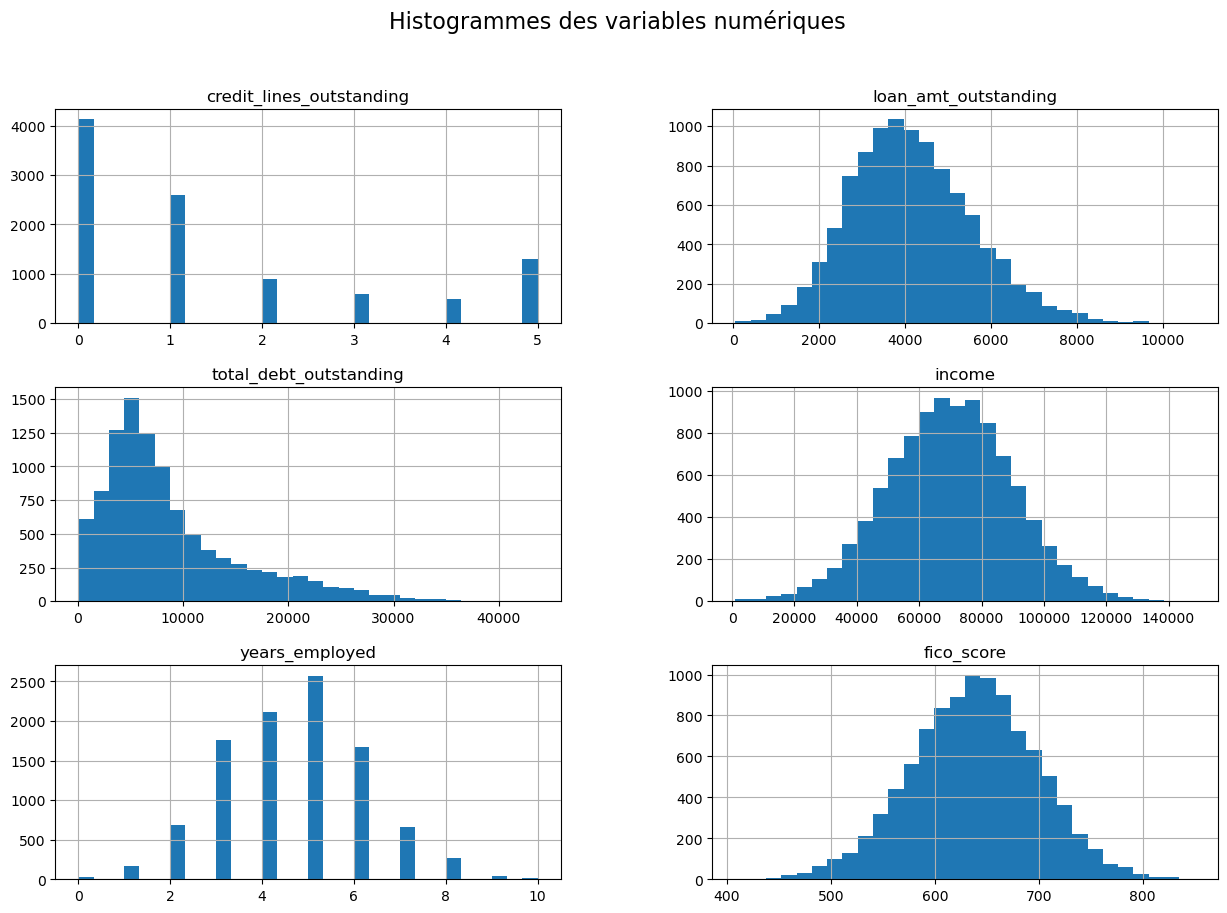

In [7]:
# --- 2.4.2 Distributions des variables numériques (Histogrammes) ---

# On sélectionne les colonnes numériques du DataFrame de modélisation (sans 'customer_id')
num_cols = df_model.select_dtypes(include=["int64", "float64"]).columns.tolist()

# On retire la cible 'default' : on ne veut pas l'inclure dans les features à visualiser
if "default" in num_cols:
    num_cols.remove("default")

# On trace un histogramme pour chaque variable numérique
# - bins=30 : nombre de barres dans l'histogramme
# - figsize=(15, 10) : taille globale de la figure
df_model[num_cols].hist(bins=30, figsize=(15, 10))

# Titre général
plt.suptitle("Histogrammes des variables numériques", fontsize=16)

# Affichage
plt.show()


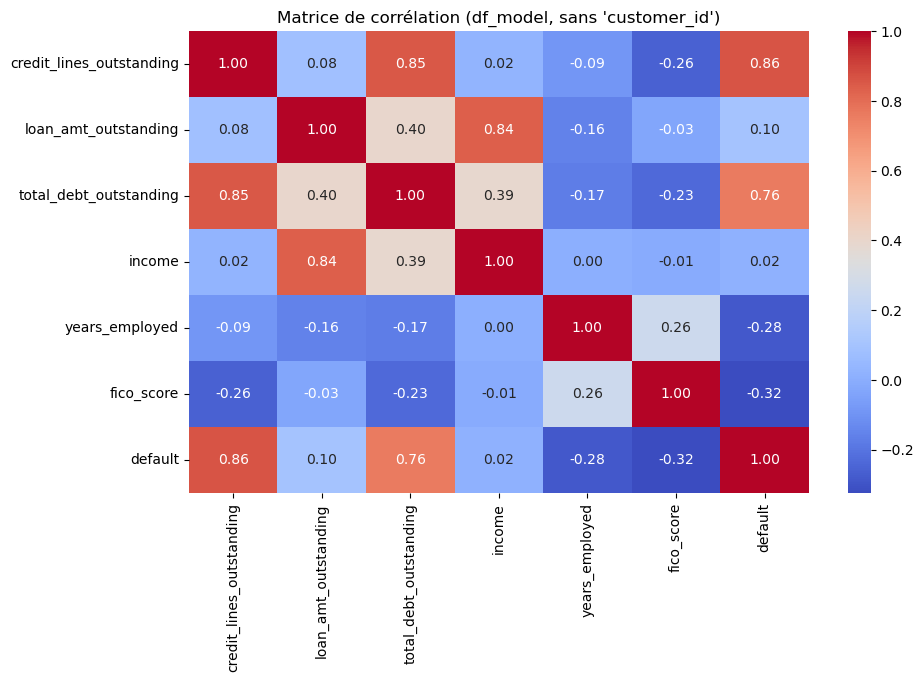

In [8]:
# --- 2.4.3 Matrice de corrélation (variables numériques + cible) ---

# On suppose que num_cols a été défini juste avant à partir de df_model
# (cf. étape 2.4.2) et qu'il NE contient PAS la cible 'default'.
# Si besoin, on peut le recalculer :
# num_cols = df_model.select_dtypes(include=["int64", "float64"]).columns.tolist()
# if "default" in num_cols: num_cols.remove("default")

plt.figure(figsize=(10, 6))

# Heatmap des corrélations :
# - on sélectionne les variables numériques + la cible 'default'
# - annot=True : affiche les coefficients
# - fmt=".2f" : 2 décimales
# - cmap="coolwarm" : bleu (corrélation négative) → rouge (positive)
sns.heatmap(
    df_model[num_cols + ["default"]].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm"
)

plt.title("Matrice de corrélation (df_model, sans 'customer_id')")
plt.show()



### 2.5 Relations clés entre les variables et la cible

Pour compléter l'analyse exploratoire, nous allons observer les différences
entre les clients en défaut (`default = 1`) et non défaut (`default = 0`) 
sur certaines variables importantes :

- **`income`** (revenu)
- **`fico_score`** (score de crédit)
- **`loan_amt_outstanding`** (montant du prêt en cours)

Nous utiliserons des **boxplots** pour comparer les distributions.


In [9]:
# --- 2.5 Relations clés entre variables et cible (boxplots interactifs) ---

import plotly.express as px

# Variables numériques à comparer à la cible 'default'
features_to_plot = ["income", "fico_score", "loan_amt_outstanding"]

# Astuce : si tu veux des libellés 0/1 bien séparés, tu peux caster 'default' en str :
# df_model["default_str"] = df_model["default"].astype(str)
# et remplacer x="default" par x="default_str" ci-dessous.

for col in features_to_plot:
    fig = px.box(
        df_model,
        x="default",          # classe cible (0 = non défaut, 1 = défaut)
        y=col,                # variable numérique à comparer
        color="default",      # couleur par classe
        points="all",         # affiche les points individuels
        title=f"{col} vs default (Boxplot interactif)"
    )
    fig.show()


## 3. Pré-traitement des données

Avant de pouvoir entraîner nos modèles de prédiction, il est nécessaire de préparer les données.  
Cette étape inclut :

- **3.1** Détection et suppression des doublons  
- **3.2** Suppression des colonnes non pertinentes (`customer_id`)  
- **3.3** Vérification des valeurs manquantes et définition d’une stratégie d’imputation  
- **3.4** Séparation du dataset en apprentissage (train) et test (80/20, stratifié)  
- **3.5** Construction d’un pipeline de pré-traitement (imputation + standardisation)  
- **3.6** Vérification du pipeline sur un échantillon (sanity check)

Ces étapes garantissent que nos données sont **propres, cohérentes et prêtes** pour l’entraînement des modèles.


### 3.1 Détection et suppression des doublons

- Vérifier les doublons sur `customer_id` (même client répété)
- Vérifier les doublons exacts de lignes
- Supprimer les doublons détectés avant de procéder au split


In [10]:
# --- 3.1 Détection et suppression des doublons ---

n_before = len(df)

# 1) Doublons sur customer_id (si la colonne existe)
if "customer_id" in df.columns:
    dup_cust = df.duplicated(subset=["customer_id"]).sum()
    print(f"Doublons sur customer_id : {dup_cust}")
    if dup_cust > 0:
        df = df.drop_duplicates(subset=["customer_id"], keep="first")
else:
    print("La colonne 'customer_id' n'existe pas dans le DataFrame.")

# 2) Doublons de lignes complètes
dup_rows = df.duplicated().sum()
print(f"Doublons de lignes complètes : {dup_rows}")
if dup_rows > 0:
    df = df.drop_duplicates(keep="first")

# 3) Reset index + log
df = df.reset_index(drop=True)
n_after = len(df)
print(f"Dimensions après nettoyage : {df.shape} (−{n_before - n_after} lignes)")


Doublons sur customer_id : 0
Doublons de lignes complètes : 0
Dimensions après nettoyage : (10000, 8) (−0 lignes)


### 3.2 Suppression des colonnes non pertinentes

- Retirer `customer_id` (identifiant, non informatif pour l’apprentissage)


In [11]:
# --- 3.2 Suppression des colonnes non pertinentes ---

# Colonnes identifiants à exclure des features (non prédictives)
ID_COLS = ["customer_id"]

# On ne supprime que les colonnes qui existent réellement dans df
cols_to_drop = [c for c in ID_COLS if c in df.columns]

# Suppression des colonnes non pertinentes
df = df.drop(columns=cols_to_drop)

# Journalisation : ce qui a été supprimé et ce qu'il reste
print("Colonnes supprimées :", cols_to_drop)
print("Colonnes restantes :", df.columns.tolist())

# On fige un DataFrame de travail pour la suite de la modélisation
# (évite toute ambiguïté avec df utilisé plus haut pour l'EDA)
df_model = df.copy()


Colonnes supprimées : ['customer_id']
Colonnes restantes : ['credit_lines_outstanding', 'loan_amt_outstanding', 'total_debt_outstanding', 'income', 'years_employed', 'fico_score', 'default']


### 3.3 Vérification des valeurs manquantes et stratégie d’imputation

- Quantifier les valeurs manquantes par variable
- Décider d’une stratégie d’imputation (médiane pour numériques)


In [12]:
# --- 3.3 Vérification des valeurs manquantes & stratégie d’imputation ---

# On vérifie les NaN sur le DataFrame de modélisation (df_model)
na_counts = df_model.isna().sum().sort_values(ascending=False)

print("Valeurs manquantes par colonne (nb) :")
print(na_counts)

# Pourcentage de NaN (plus lisible quand il y en a peu)
na_pct = (df_model.isna().mean() * 100).round(2)
print("\nValeurs manquantes par colonne (%) :")
print(na_pct)

# (Optionnel) Focus uniquement sur les colonnes qui ont au moins 1 NaN
na_nonzero = na_counts[na_counts > 0]
if len(na_nonzero) == 0:
    print("\n✅ Aucune valeur manquante détectée — imputation par médiane restera sans effet (sécurise le pipeline).")
else:
    print("\n⚠️ Colonnes avec NaN détectés (à imputer) :")
    print(na_nonzero)


Valeurs manquantes par colonne (nb) :
credit_lines_outstanding    0
loan_amt_outstanding        0
total_debt_outstanding      0
income                      0
years_employed              0
fico_score                  0
default                     0
dtype: int64

Valeurs manquantes par colonne (%) :
credit_lines_outstanding    0.0
loan_amt_outstanding        0.0
total_debt_outstanding      0.0
income                      0.0
years_employed              0.0
fico_score                  0.0
default                     0.0
dtype: float64

✅ Aucune valeur manquante détectée — imputation par médiane restera sans effet (sécurise le pipeline).


### 3.4 Séparation train / test (stratifiée)

- Définir la cible `default`
- Séparer en apprentissage (80%) et test (20%) en conservant le ratio de classes


In [13]:
# --- 3.4 Séparation train / test (stratifiée) ---

from sklearn.model_selection import train_test_split

# Nom de la cible
TARGET = "default"

# On travaille sur le DataFrame de modélisation (df_model), déjà sans 'customer_id'
# -> FEATURES = toutes les colonnes sauf la cible
FEATURES = [c for c in df_model.columns if c != TARGET]

# Séparation features / cible
X = df_model[FEATURES].copy()
y = df_model[TARGET].astype(int).copy()  # on force en int par sécurité

# Split stratifié pour conserver le ratio de classes entre train et test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 20% test / 80% train
    stratify=y,         # conserve la proportion de la classe minoritaire
    random_state=42     # reproductibilité
)

# (Optionnel) garder l'ordre exact des colonnes pour l'app de déploiement
FEATURE_ORDER = FEATURES

# Contrôles rapides
print("Train :", X_train.shape, "| Test :", X_test.shape)
print("Taux de défaut - train:", y_train.mean().round(3), "| test:", y_test.mean().round(3))


Train : (8000, 6) | Test : (2000, 6)
Taux de défaut - train: 0.185 | test: 0.185


### 3.5 Pipeline de pré-traitement

- Imputation **médiane** pour toutes les variables numériques
- Standardisation (**StandardScaler**) pour homogénéiser les échelles


In [14]:
# --- 3.5 Pipeline de pré-traitement ---

from sklearn.compose import ColumnTransformer      # Pour cibler des groupes de colonnes
from sklearn.pipeline import Pipeline              # Pour chaîner les étapes
from sklearn.impute import SimpleImputer           # Gestion des valeurs manquantes
from sklearn.preprocessing import StandardScaler   # Mise à l'échelle

# Ici, toutes les features sont numériques → on sélectionne simplement toutes les colonnes de X_train
num_cols = X_train.columns.tolist()

# Pipeline de pré-traitement appliqué aux colonnes numériques :
# 1) Imputation par la médiane (robuste aux outliers)
# 2) Standardisation (moyenne=0, écart-type=1) pour aider certains modèles (ex: régression logistique)
preproc = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler())
            ]),
            num_cols
        )
    ],
    remainder="drop"  # Ici inutile car toutes les colonnes sont numériques, mais on explicite le comportement
)

# Affiche la structure du préprocesseur (utile en debug / soutenance)
preproc


,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


### 3.6 Sanity check du pipeline

- Vérifier que le pipeline `fit_transform` fonctionne sur le train
- Appliquer `transform` sur le test sans erreur


In [15]:
# Application du pipeline de prétraitement (fit + transform) sur les données d'entraînement
Xt_train = preproc.fit_transform(X_train)

# Application du pipeline de prétraitement (transform seul) sur les données de test
Xt_test  = preproc.transform(X_test)

# Affichage des dimensions des matrices transformées
print("Shape Xt_train :", Xt_train.shape)
print("Shape Xt_test  :", Xt_test.shape)


Shape Xt_train : (8000, 6)
Shape Xt_test  : (2000, 6)


## 4. Modélisation

Une fois les données préparées, nous passons à l’entraînement des modèles de classification.  
L’objectif est de comparer plusieurs algorithmes afin de sélectionner celui qui offre les meilleures performances pour la **prédiction du risque de défaut de paiement**.

Nous adopterons une approche expérimentale, traçant et évaluant nos modèles avec **MLflow** pour assurer la traçabilité MLOps.

Le processus est structuré en plusieurs sous-sections :

- **4.1** Définition des métriques d’évaluation  
- **4.2** Entraînement d’un modèle de **régression logistique**  
- **4.3** Entraînement d’un **arbre de décision**  
- **4.4** Entraînement d’une **forêt aléatoire (Random Forest)**  
- **4.5** Comparaison des résultats obtenus (tableau récapitulatif)  
- **4.6** Sélection du meilleur modèle et calibration éventuelle  

Ces étapes permettront d’identifier un modèle **robuste**, **interprétable** et **prêt à être déployé** en production.



### 4.1 Définition des métriques d’évaluation

Pour évaluer la performance de nos modèles, nous utiliserons plusieurs métriques complémentaires :

- **ROC-AUC** : mesure la capacité du modèle à discriminer entre défaut et non défaut, indépendamment d’un seuil.  
- **PR-AUC (Average Precision)** : adaptée aux classes déséquilibrées, elle évalue la précision en fonction du rappel.  
- **Brier Score** : mesure la qualité de calibration des probabilités prédites (plus c’est bas, mieux c’est).  
- **Matrice de confusion** : permet d’observer les vrais positifs/négatifs et faux positifs/négatifs après choix d’un seuil.  
- **Rapport de classification** (précision, rappel, F1-score).

Ces métriques nous donneront une vision complète de la performance et de la fiabilité des modèles.


In [16]:
# --- 4.1 Définition des métriques d’évaluation (fonction générique) ---

from typing import Dict, Any
import numpy as np
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    confusion_matrix, classification_report
)

def _get_proba(estimator, X) -> np.ndarray:
    """
    Renvoie la probabilité de la classe positive pour chaque échantillon.
    - Utilise predict_proba si disponible.
    - Sinon, fallback sur decision_function avec une sigmoïde (approx proba).
    - En dernier recours, utilise predict (peu informatif pour AUC/PR).
    """
    if hasattr(estimator, "predict_proba"):
        return estimator.predict_proba(X)[:, 1]
    elif hasattr(estimator, "decision_function"):
        scores = estimator.decision_function(X)
        return 1 / (1 + np.exp(-scores))  # transformation sigmoïde
    else:
        # Dernier recours : valeurs 0/1 converties en float
        return estimator.predict(X).astype(float)

def eval_model(model, X_train, y_train, X_test, y_test, threshold: float = 0.5) -> Dict[str, Any]:
    """
    Entraîne un estimateur (ou Pipeline sklearn) et calcule des métriques complètes.

    Paramètres
    ----------
    model : sklearn estimator ou Pipeline
        Doit implémenter .fit() et de préférence .predict_proba() ou .decision_function().
    X_train, y_train : array-like
        Données d'entraînement (features et cible).
    X_test, y_test : array-like
        Données de test (features et cible).
    threshold : float, par défaut 0.5
        Seuil pour convertir les probabilités en classes (0/1).

    Retour
    ------
    Dict[str, Any] :
        - 'roc_auc_train' / 'roc_auc_test' : AUC ROC
        - 'pr_auc_train' / 'pr_auc_test'   : Average Precision (aire PR)
        - 'brier_test'                     : Brier score sur test (calibration)
        - 'threshold'                      : seuil utilisé
        - 'confusion_matrix'               : matrice de confusion @ threshold
        - 'classification_report'          : précision/rappel/F1 formaté
        - 'y_test' / 'proba_test' / 'preds_test' : utiles pour tracés/analyses
    """
    # 1) Entraînement
    model.fit(X_train, y_train)

    # 2) Probabilités (train/test)
    proba_train = _get_proba(model, X_train)
    proba_test  = _get_proba(model, X_test)

    # 3) Métriques principales
    results: Dict[str, Any] = {
        "roc_auc_train": float(roc_auc_score(y_train, proba_train)),
        "roc_auc_test":  float(roc_auc_score(y_test,  proba_test)),
        "pr_auc_train":  float(average_precision_score(y_train, proba_train)),
        "pr_auc_test":   float(average_precision_score(y_test,  proba_test)),
        "brier_test":    float(brier_score_loss(y_test, proba_test)),
        "threshold":     float(threshold),
    }

    # 4) Prédictions binaires @ threshold
    preds = (proba_test >= threshold).astype(int)

    # 5) Détails de classification
    results["confusion_matrix"] = confusion_matrix(y_test, preds).tolist()
    results["classification_report"] = classification_report(y_test, preds, digits=3)

    # 6) Objets utiles pour tracés ultérieurs (ROC/PR) et sauvegardes
    results["y_test"] = y_test.tolist()
    results["proba_test"] = proba_test.tolist()
    results["preds_test"] = preds.tolist()

    return results


### 4.2 Régression Logistique

La régression logistique est un modèle de base, interprétable et largement utilisé dans le scoring de crédit.  
Nous allons l’entraîner sur nos données pré-traitées et évaluer ses performances avec les métriques définies en 4.1.


#### 4.2.1 Entraînement – Régression logistique

Nous entraînons un modèle de **régression logistique** encapsulé dans un pipeline
qui applique le **pré-traitement** (`preproc`) puis l’estimateur.
  
Cette étape ajuste le modèle sur l’échantillon **train**.



In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Pipeline = prétraitement + modèle
logreg = Pipeline(steps=[
    ("preproc", preproc),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="lbfgs",     # optionnel, mais explicite
        random_state=42
    ))
])

# Évaluation (eval_model fait le .fit() en interne)
logreg_metrics = eval_model(
    model=logreg,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    threshold=0.5
)

print("AUC ROC (test):", round(logreg_metrics["roc_auc_test"], 3))
print("PR AUC  (test):", round(logreg_metrics["pr_auc_test"], 3))
print("Brier   (test):", round(logreg_metrics["brier_test"], 4))
print("\nRapport de classification @0.5:\n", logreg_metrics["classification_report"])


AUC ROC (test): 1.0
PR AUC  (test): 1.0
Brier   (test): 0.0047

Rapport de classification @0.5:
               precision    recall  f1-score   support

           0      1.000     0.994     0.997      1630
           1      0.976     1.000     0.988       370

    accuracy                          0.996      2000
   macro avg      0.988     0.997     0.993      2000
weighted avg      0.996     0.996     0.996      2000



#### 4.2.2 Affichage des performances du modèle

Les performances du modèle de **régression logistique** ont été évaluées automatiquement 
dans la fonction `eval_model()` (qui effectue à la fois l’entraînement et le calcul des métriques principales).

Nous affichons ici les résultats obtenus sur l’échantillon **test** :

- **ROC-AUC** : mesure la capacité du modèle à distinguer défaut vs non défaut,  
- **PR-AUC** : adaptée aux classes déséquilibrées,  
- **Brier Score** : évalue la qualité de la calibration des probabilités,  
- **Matrice de confusion** et **rapport de classification** : détaillent les prédictions au seuil 0,5.


In [19]:
# Réutilisation des résultats calculés par eval_model (aucun fit ici)

import numpy as np

print("===== Évaluation Régression Logistique =====")
print(f"ROC-AUC (test)  : {logreg_metrics['roc_auc_test']:.3f}")
print(f"PR-AUC  (test)  : {logreg_metrics['pr_auc_test']:.3f}")
print(f"Brier score     : {logreg_metrics['brier_test']:.4f}")
print("--------------------------------------------")
print("Matrice de confusion :\n", np.array(logreg_metrics["confusion_matrix"]))
print("--------------------------------------------")
print("Rapport de classification :")
print(logreg_metrics["classification_report"])


===== Évaluation Régression Logistique =====
ROC-AUC (test)  : 1.000
PR-AUC  (test)  : 1.000
Brier score     : 0.0047
--------------------------------------------
Matrice de confusion :
 [[1621    9]
 [   0  370]]
--------------------------------------------
Rapport de classification :
              precision    recall  f1-score   support

           0      1.000     0.994     0.997      1630
           1      0.976     1.000     0.988       370

    accuracy                          0.996      2000
   macro avg      0.988     0.997     0.993      2000
weighted avg      0.996     0.996     0.996      2000



#### 4.2.3 Interprétation et visualisation de la matrice de confusion

Nous interprétons ici les résultats au **seuil 0,5**, en **réutilisant les sorties de `eval_model`**  
(aucun ré-entraînement ni nouvelle prédiction).

- **TN (True Negatives)** : non-défauts correctement prédits  
- **FP (False Positives)** : non-défauts prédits à tort comme défauts  
- **FN (False Negatives)** : défauts non détectés (erreurs critiques côté risque)  
- **TP (True Positives)** : défauts correctement identifiés  

Nous affichons :
1) les **valeurs numériques** de la matrice de confusion pour une lecture précise ;  
2) une **heatmap** (carte thermique) pour une visualisation immédiate.

> Remarque : sur un jeu **déséquilibré**, l’accuracy peut être trompeuse ; on privilégie **ROC-AUC**, **PR-AUC**, et le **Recall** selon le coût métier des FN/FP.


===== Matrice de confusion – Régression Logistique =====
Lignes = Valeurs réelles | Colonnes = Prédictions

Vrais négatifs (TN) : 1621
Faux positifs  (FP) : 9
Faux négatifs  (FN) : 0
Vrais positifs  (TP) : 370

Exactitude globale (accuracy) : 99.550%


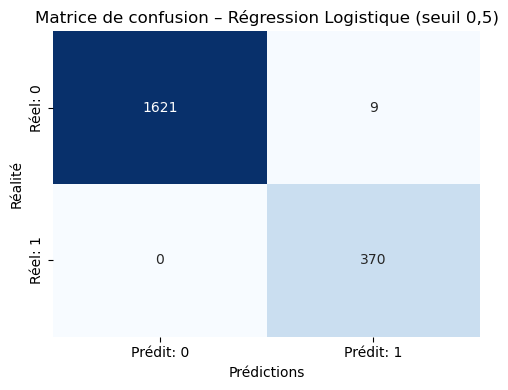

In [21]:
# --- 4.2.3 Interprétation et visualisation de la matrice de confusion ---

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# On réutilise les sorties de eval_model (aucun fit ni prédiction ici)
y_true = np.array(logreg_metrics["y_test"])
y_pred = np.array(logreg_metrics["preds_test"])

# 📌 Matrice de confusion
cm = confusion_matrix(y_true, y_pred)

print("===== Matrice de confusion – Régression Logistique =====")
print("Lignes = Valeurs réelles | Colonnes = Prédictions\n")

# Décomposition pour interprétation
TN, FP, FN, TP = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]

print(f"Vrais négatifs (TN) : {TN}")
print(f"Faux positifs  (FP) : {FP}")
print(f"Faux négatifs  (FN) : {FN}")
print(f"Vrais positifs  (TP) : {TP}")

# ✅ Exactitude globale (attention : à ne pas confondre avec AUC/F1)
accuracy = (TP + TN) / cm.sum()
print(f"\nExactitude globale (accuracy) : {accuracy:.3%}")

# 🔥 Heatmap pour lecture visuelle
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True, fmt="d", cbar=False,
    cmap="Blues",
    xticklabels=["Prédit: 0", "Prédit: 1"],
    yticklabels=["Réel: 0", "Réel: 1"]
)
plt.title("Matrice de confusion – Régression Logistique (seuil 0,5)")
plt.xlabel("Prédictions")
plt.ylabel("Réalité")
plt.tight_layout()
plt.show()


### 4.3 Arbre de Décision

L’arbre de décision est un modèle simple et interprétable, qui segmente les
données en suivant une logique de règles « si… alors… ».  
Nous allons l’entraîner, évaluer ses performances puis visualiser la matrice de confusion.


#### 4.3.1 Entraînement et évaluation – Arbre de Décision

L’arbre de décision est un modèle simple et interprétable, basé sur une succession
de règles de type **« si… alors… »**.

Nous entraînons ici un **pipeline complet** combinant :
- le **pré-traitement** des variables (imputation + standardisation),
- un **arbre de décision** limité en profondeur (`max_depth=6`)
  pour éviter le surapprentissage,
- et une **pondération automatique des classes** (`class_weight="balanced"`)
  afin de compenser le déséquilibre de la variable cible.

L’évaluation est réalisée via la fonction `eval_model()` qui calcule :
- ROC-AUC, PR-AUC et Brier score,
- le rapport de classification détaillé au seuil 0,5.


In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

# --- 4.3.1 Entraînement et évaluation - Arbre de Décision ---

# Pipeline = prétraitement + modèle
tree = Pipeline(steps=[
    ("preproc", preproc),
    ("clf", DecisionTreeClassifier(
        max_depth=6,              # Profondeur limitée pour éviter l’overfitting
        class_weight="balanced",  # Pondération automatique des classes
        random_state=42
    ))
])

# Évaluation complète via eval_model (fit + métriques)
tree_metrics = eval_model(
    model=tree,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    threshold=0.5
)

# Résumé rapide des résultats
print("===== Évaluation Arbre de Décision =====")
print(f"ROC-AUC (test) : {tree_metrics['roc_auc_test']:.3f}")
print(f"PR-AUC  (test) : {tree_metrics['pr_auc_test']:.3f}")
print(f"Brier score    : {tree_metrics['brier_test']:.4f}")
print("--------------------------------------------")
print("Rapport de classification :")
print(tree_metrics["classification_report"])


===== Évaluation Arbre de Décision =====
ROC-AUC (test) : 0.997
PR-AUC  (test) : 0.995
Brier score    : 0.0038
--------------------------------------------
Rapport de classification :
              precision    recall  f1-score   support

           0      0.999     0.996     0.997      1630
           1      0.981     0.995     0.988       370

    accuracy                          0.996      2000
   macro avg      0.990     0.995     0.993      2000
weighted avg      0.996     0.996     0.996      2000



#### 4.3.2 Affichage des performances (test)

Les performances de l’**arbre de décision** ont été calculées par `eval_model()`  
(qui effectue à la fois l’entraînement et l’évaluation).  
Nous affichons ici les métriques **déjà calculées** sur le set **test**.


In [23]:
# --- 4.3.2 Affichage des performances (test) ---

# On réutilise les résultats calculés par eval_model (aucun fit ni predict_proba ici)
import numpy as np

print("===== Évaluation Arbre de Décision =====")
print(f"ROC-AUC (test)  : {tree_metrics['roc_auc_test']:.3f}")
print(f"PR-AUC  (test)  : {tree_metrics['pr_auc_test']:.3f}")
print(f"Brier score     : {tree_metrics['brier_test']:.4f}")
print("--------------------------------------------")

# Matrice de confusion (déjà calculée au seuil 0.5 par eval_model)
cm = np.array(tree_metrics["confusion_matrix"])
print("Matrice de confusion :\n", cm)

print("--------------------------------------------")
print("Rapport de classification :")
print(tree_metrics["classification_report"])



===== Évaluation Arbre de Décision =====
ROC-AUC (test)  : 0.997
PR-AUC  (test)  : 0.995
Brier score     : 0.0038
--------------------------------------------
Matrice de confusion :
 [[1623    7]
 [   2  368]]
--------------------------------------------
Rapport de classification :
              precision    recall  f1-score   support

           0      0.999     0.996     0.997      1630
           1      0.981     0.995     0.988       370

    accuracy                          0.996      2000
   macro avg      0.990     0.995     0.993      2000
weighted avg      0.996     0.996     0.996      2000



#### 4.3.3 Interprétation et visualisation de la matrice de confusion

Nous analysons ici la **matrice de confusion** de l’**arbre de décision** au **seuil 0,5**,  
en **réutilisant la matrice calculée par `eval_model()`** (aucun ré-entraînement ni nouvelle prédiction).

- **TN (True Negatives)** : non-défauts correctement prédits  
- **FP (False Positives)** : non-défauts classés à tort comme défauts  
- **FN (False Negatives)** : défauts non détectés (erreurs critiques côté risque)  
- **TP (True Positives)** : défauts correctement identifiés  

Nous affichons :
1) les **valeurs numériques** (TN, FP, FN, TP) pour une lecture précise ;  
2) une **heatmap** pour une visualisation rapide et intuitive.

> Remarque : l’**accuracy** peut être trompeuse en présence d’un **déséquilibre de classes**.  
> Nous privilégions l’analyse de **ROC-AUC**, **PR-AUC** et du **Recall** selon le coût métier des erreurs.


===== Matrice de confusion – Arbre de Décision =====
Lignes = Valeurs réelles | Colonnes = Prédictions

Vrais négatifs (TN) : 1623
Faux positifs  (FP) : 7
Faux négatifs  (FN) : 2
Vrais positifs  (TP) : 368

Exactitude globale (accuracy) : 99.550%


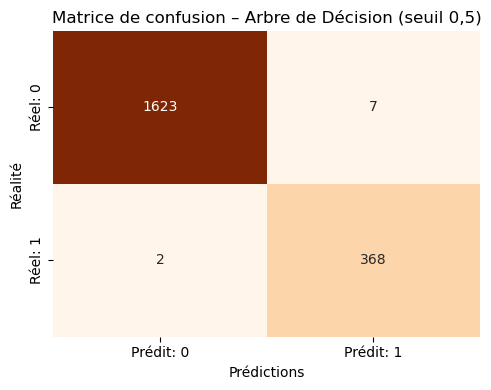

In [24]:
# --- 4.3.3 Interprétation et visualisation de la matrice de confusion ---

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# On réutilise la matrice calculée par eval_model (aucun fit / aucune prédiction ici)
cm_tree = np.array(tree_metrics["confusion_matrix"])

print("===== Matrice de confusion – Arbre de Décision =====")
print("Lignes = Valeurs réelles | Colonnes = Prédictions\n")

# Décomposition TN/FP/FN/TP
TN, FP, FN, TP = cm_tree[0, 0], cm_tree[0, 1], cm_tree[1, 0], cm_tree[1, 1]
print(f"Vrais négatifs (TN) : {TN}")
print(f"Faux positifs  (FP) : {FP}")
print(f"Faux négatifs  (FN) : {FN}")
print(f"Vrais positifs  (TP) : {TP}")

# Exactitude (information complémentaire, à interpréter avec précaution en dataset déséquilibré)
accuracy_tree = (TP + TN) / cm_tree.sum()
print(f"\nExactitude globale (accuracy) : {accuracy_tree:.3%}")

# Heatmap pour la lecture visuelle
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_tree,
    annot=True, fmt="d", cbar=False,
    cmap="Oranges",
    xticklabels=["Prédit: 0", "Prédit: 1"],
    yticklabels=["Réel: 0", "Réel: 1"]
)
plt.title("Matrice de confusion – Arbre de Décision (seuil 0,5)")
plt.xlabel("Prédictions")
plt.ylabel("Réalité")
plt.tight_layout()
plt.show()


### 4.4 Random Forest

La **forêt aléatoire** est un ensemble d’arbres de décision entraînés sur des sous-échantillons
des données et des variables.  
Elle permet en général d’obtenir de meilleures performances et une meilleure robustesse qu’un arbre unique.  

Nous allons l’entraîner, évaluer ses performances, puis analyser la matrice de confusion.


#### 4.4.1 Entraînement et évaluation – Random Forest

La **Random Forest** combine plusieurs arbres de décision entraînés sur des sous-échantillons des données.  
Ce modèle est plus robuste qu’un arbre unique et réduit la variance tout en conservant une bonne interprétabilité.

Nous utilisons ici :
- **500 arbres** (`n_estimators=500`) pour la stabilité,
- une **profondeur maximale de 10** pour limiter le surapprentissage,
- un **poids de classes équilibré** (`class_weight='balanced_subsample'`).

L’évaluation est réalisée via la fonction `eval_model()` qui gère l’entraînement, le calcul des métriques et la génération des rapports.


In [25]:
#### 4.4.1 Entraînement et évaluation – Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Pipeline = prétraitement + modèle
rf = Pipeline(steps=[
    ("preproc", preproc),
    ("clf", RandomForestClassifier(
        n_estimators=500,              # Nombre d’arbres dans la forêt
        max_depth=10,                  # Profondeur maximale des arbres
        min_samples_leaf=5,            # Nombre minimum d’échantillons dans une feuille
        max_features="sqrt",           # Sélection aléatoire des features à chaque split
        class_weight="balanced_subsample",  # Gestion du déséquilibre des classes
        random_state=42,               # Reproductibilité
        n_jobs=-1                      # Utilisation maximale des cœurs CPU
    ))
])

# Évaluation complète via eval_model (fit + métriques)
rf_metrics = eval_model(
    model=rf,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    threshold=0.5
)

# Résumé rapide des résultats
print("===== Évaluation Random Forest =====")
print(f"ROC-AUC (test) : {rf_metrics['roc_auc_test']:.3f}")
print(f"PR-AUC  (test) : {rf_metrics['pr_auc_test']:.3f}")
print(f"Brier score    : {rf_metrics['brier_test']:.4f}")
print("--------------------------------------------")
print("Rapport de classification :")
print(rf_metrics["classification_report"])


===== Évaluation Random Forest =====
ROC-AUC (test) : 1.000
PR-AUC  (test) : 0.999
Brier score    : 0.0062
--------------------------------------------
Rapport de classification :
              precision    recall  f1-score   support

           0      0.998     0.994     0.996      1630
           1      0.973     0.992     0.983       370

    accuracy                          0.994      2000
   macro avg      0.986     0.993     0.989      2000
weighted avg      0.994     0.994     0.994      2000



#### 4.4.2 Affichage des performances (test)

Nous réutilisons ici les **résultats calculés automatiquement par `eval_model()`** pour la **Random Forest**,  
sans refaire de `fit` ni de prédiction manuelle.

Les principales métriques affichées sont :

- **ROC-AUC** : capacité du modèle à bien classer les défauts et non-défauts  
- **PR-AUC** : précision en fonction du rappel, adaptée aux jeux de données déséquilibrés  
- **Brier score** : mesure la qualité de calibration des probabilités prédites  
- **Matrice de confusion** : erreurs de classification au seuil 0,5  
- **Rapport de classification** : précision, rappel et F1-score par classe

> Cette approche permet de comparer directement les modèles précédents sur des bases identiques.


In [26]:
# --- 4.4.2 Affichage des performances (test) ---

import numpy as np

print("===== Évaluation Random Forest =====")
print(f"ROC-AUC (test)  : {rf_metrics['roc_auc_test']:.3f}")
print(f"PR-AUC  (test)  : {rf_metrics['pr_auc_test']:.3f}")
print(f"Brier score     : {rf_metrics['brier_test']:.4f}")
print("--------------------------------------------")
print("Matrice de confusion :\n", np.array(rf_metrics["confusion_matrix"]))
print("--------------------------------------------")
print("Rapport de classification :")
print(rf_metrics["classification_report"])


===== Évaluation Random Forest =====
ROC-AUC (test)  : 1.000
PR-AUC  (test)  : 0.999
Brier score     : 0.0062
--------------------------------------------
Matrice de confusion :
 [[1620   10]
 [   3  367]]
--------------------------------------------
Rapport de classification :
              precision    recall  f1-score   support

           0      0.998     0.994     0.996      1630
           1      0.973     0.992     0.983       370

    accuracy                          0.994      2000
   macro avg      0.986     0.993     0.989      2000
weighted avg      0.994     0.994     0.994      2000



#### 4.4.2-bis Courbes ROC et Precision-Recall

Pour compléter l’évaluation, nous visualisons les courbes :

- **ROC (Receiver Operating Characteristic)** : compare le **taux de vrais positifs** et le **taux de faux positifs**  
- **Precision-Recall** : met en évidence la capacité du modèle à maintenir une bonne précision malgré le déséquilibre des classes

Ces deux graphiques donnent une **lecture visuelle immédiate** de la performance du modèle,  
indépendamment du seuil de décision (0,5 ici).

> Les courbes seront également enregistrées dans **MLflow** afin de pouvoir les consulter directement dans l’interface d’expérimentation.


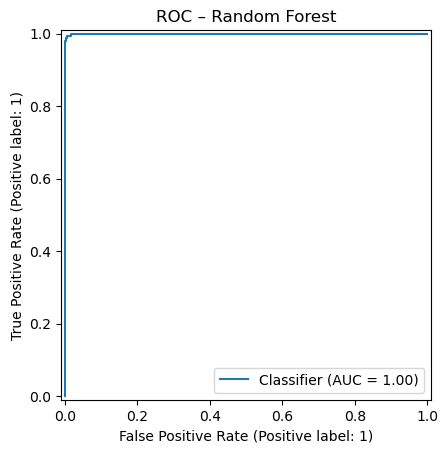

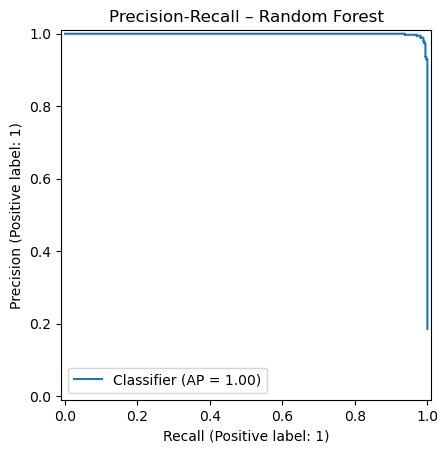

In [27]:
# --- 4.4.2-bis Courbes ROC & Precision-Recall (visuel) ---

from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt
import numpy as np

y_true = np.array(rf_metrics["y_test"])
p_test = np.array(rf_metrics["proba_test"])

RocCurveDisplay.from_predictions(y_true, p_test)
plt.title("ROC – Random Forest")
plt.show()

PrecisionRecallDisplay.from_predictions(y_true, p_test)
plt.title("Precision-Recall – Random Forest")
plt.show()


#### 4.4.3 Interprétation et visualisation de la matrice de confusion

Nous interprétons la **Random Forest** au **seuil 0,5** en **réutilisant la matrice calculée par `eval_model()`**  
(aucun ré-entraînement ni nouvelle prédiction).

- **TN (True Negatives)**, **FP (False Positives)**, **FN (False Negatives)**, **TP (True Positives)**
- **Accuracy** (à interpréter avec prudence en cas de déséquilibre de classes)
- **Heatmap** (carte thermique) pour une lecture visuelle immédiate


===== Matrice de confusion – Random Forest =====
Lignes = Valeurs réelles | Colonnes = Prédictions

Vrais négatifs (TN) : 1620
Faux positifs  (FP) : 10
Faux négatifs  (FN) : 3
Vrais positifs  (TP) : 367

Exactitude globale (accuracy) : 99.350%


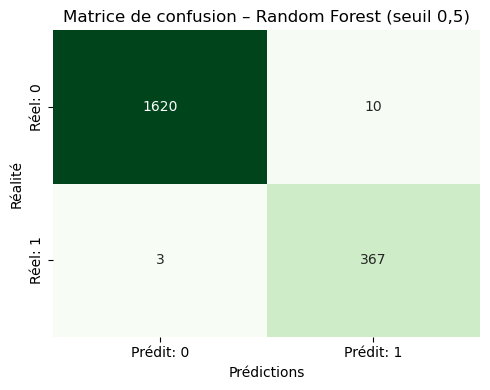

In [28]:
# --- 4.4.3 Interprétation et visualisation de la matrice de confusion ---

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Réutilisation de la matrice fournie par eval_model (aucun fit / aucune prédiction ici)
cm_rf = np.array(rf_metrics["confusion_matrix"])

print("===== Matrice de confusion – Random Forest =====")
print("Lignes = Valeurs réelles | Colonnes = Prédictions\n")

# Décomposition TN/FP/FN/TP
TN, FP, FN, TP = cm_rf[0, 0], cm_rf[0, 1], cm_rf[1, 0], cm_rf[1, 1]
print(f"Vrais négatifs (TN) : {TN}")
print(f"Faux positifs  (FP) : {FP}")
print(f"Faux négatifs  (FN) : {FN}")
print(f"Vrais positifs  (TP) : {TP}")

# Accuracy (info complémentaire ; privilégier AUC/PR-AUC/Recall en dataset déséquilibré)
accuracy_rf = (TP + TN) / cm_rf.sum()
print(f"\nExactitude globale (accuracy) : {accuracy_rf:.3%}")

# Heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_rf,
    annot=True, fmt="d", cbar=False,
    cmap="Greens",
    xticklabels=["Prédit: 0", "Prédit: 1"],
    yticklabels=["Réel: 0", "Réel: 1"]
)
plt.title("Matrice de confusion – Random Forest (seuil 0,5)")
plt.xlabel("Prédictions")
plt.ylabel("Réalité")
plt.tight_layout()
plt.show()


### 4.5 Comparaison des modèles

Nous comparons les trois modèles sur le jeu **test** à l’aide des métriques suivantes :

- **ROC-AUC** : capacité de discrimination globale  
- **PR-AUC** : précision en fonction du rappel, adaptée aux jeux de données déséquilibrés  
- **Brier score** : qualité de calibration des probabilités (plus il est faible, mieux c’est)  
- **Accuracy** : proportion de bonnes prédictions au seuil 0,5  

Les résultats sont présentés dans un tableau comparatif, trié par **PR-AUC** puis **ROC-AUC**,  
afin d’identifier le **meilleur modèle global**.

> Le tableau est également exporté sous le nom `comparaison_modeles.csv` pour archivage.


In [32]:
# --- 4.5 Comparaison des modèles (aligné avec eval_model actuel) ---

import numpy as np
import pandas as pd

def accuracy_from_cm(cm):
    """Calcule l'accuracy à partir d'une matrice de confusion [[TN, FP],[FN, TP]]."""
    cm = np.array(cm)
    return (cm[0, 0] + cm[1, 1]) / cm.sum()

rows = [
    {
        "model": "Logistic Regression",
        "roc_auc": logreg_metrics["roc_auc_test"],
        "pr_auc":  logreg_metrics["pr_auc_test"],
        "brier":   logreg_metrics["brier_test"],
        "accuracy": accuracy_from_cm(logreg_metrics["confusion_matrix"]),
    },
    {
        "model": "Decision Tree",
        "roc_auc": tree_metrics["roc_auc_test"],
        "pr_auc":  tree_metrics["pr_auc_test"],
        "brier":   tree_metrics["brier_test"],
        "accuracy": accuracy_from_cm(tree_metrics["confusion_matrix"]),
    },
    {
        "model": "Random Forest",
        "roc_auc": rf_metrics["roc_auc_test"],
        "pr_auc":  rf_metrics["pr_auc_test"],
        "brier":   rf_metrics["brier_test"],
        "accuracy": accuracy_from_cm(rf_metrics["confusion_matrix"]),
    },
]

df_cmp = pd.DataFrame(rows)[["model", "roc_auc", "pr_auc", "brier", "accuracy"]]
df_cmp_sorted = df_cmp.sort_values(["pr_auc", "roc_auc"], ascending=False).reset_index(drop=True)

display(
    df_cmp_sorted.style.format({
        "roc_auc": "{:.3f}",
        "pr_auc": "{:.3f}",
        "brier": "{:.3f}",
        "accuracy": "{:.3%}",
    })
)

best_model_name = df_cmp_sorted.loc[0, "model"]
print(f"\n➡️ Meilleur modèle (par PR-AUC puis ROC-AUC) : **{best_model_name}**")

# (optionnel) export
df_cmp_sorted.to_csv("comparaison_modeles.csv", index=False)
print("✅ Tableau enregistré dans comparaison_modeles.csv")


,model,roc_auc,pr_auc,brier,accuracy
0,Logistic Regression,1.000,1.000,0.005,99.550%
1,Random Forest,1.000,0.999,0.006,99.350%
2,Decision Tree,0.997,0.995,0.004,99.550%



➡️ Meilleur modèle (par PR-AUC puis ROC-AUC) : **Logistic Regression**
✅ Tableau enregistré dans comparaison_modeles.csv


### 4.6 Sauvegarde du modèle final et des artefacts

Une fois le meilleur modèle identifié, nous procédons à la **sauvegarde complète** pour utilisation ultérieure.

Les fichiers suivants sont générés dans le dossier `artifacts/` :

- Le **pipeline complet** (prétraitement + modèle entraîné) au format `.joblib`
- Le **tableau comparatif** des performances des modèles (`comparaison_modeles.csv`)
- Les **métriques du meilleur modèle** au format `.json`

> Ces fichiers seront utilisés dans la suite du projet pour le **déploiement du modèle** (API Streamlit et suivi MLflow).


In [34]:
# --- 4.6 Sauvegarde du meilleur modèle et des artefacts (corrigé) ---

from pathlib import Path
import json, joblib
import numpy as np

# Helper: accuracy depuis la matrice de confusion
def accuracy_from_cm(cm):
    cm = np.array(cm)
    return float((cm[0, 0] + cm[1, 1]) / cm.sum())

# 1) Dossier artifacts
ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# 2) Meilleur modèle (depuis le tableau comparatif)
best_model_name = df_cmp_sorted.loc[0, "model"]
print(f"➡️ Meilleur modèle sélectionné : {best_model_name}")

# 3) Associer au bon pipeline + métriques (issues d'eval_model)
if best_model_name == "Logistic Regression":
    best_model = logreg          # pipeline défini plus haut
    best_metrics = logreg_metrics
elif best_model_name == "Decision Tree":
    best_model = tree
    best_metrics = tree_metrics
elif best_model_name == "Random Forest":
    best_model = rf
    best_metrics = rf_metrics
else:
    raise ValueError("❌ Modèle non reconnu parmi les résultats comparés.")

# ⚠️ IMPORTANT : le pipeline n'est pas forcément fit() (eval_model fit en interne)
# On le réentraîne ici AVANT sauvegarde. Choix simple et cohérent : refit sur le train.
best_model.fit(X_train, y_train)

# 4) Sauvegarde du pipeline (préproc + estimateur)
model_filename = best_model_name.replace(" ", "_").lower() + "_final.joblib"
model_path = ARTIFACTS_DIR / model_filename
joblib.dump(best_model, model_path)
print(f"✅ Modèle sauvegardé dans : {model_path}")

# 5) Sauvegarde du tableau comparatif
cmp_path = ARTIFACTS_DIR / "comparaison_modeles.csv"
df_cmp_sorted.to_csv(cmp_path, index=False)
print(f"✅ Tableau comparatif enregistré dans : {cmp_path}")

# 6) Sauvegarde des métriques du meilleur modèle (JSON)
#    👉 on n'utilise pas y_test/proba_test ici ; on prend l'accuracy via la matrice de confusion
metrics = {
    "model": best_model_name,
    "roc_auc": float(best_metrics["roc_auc_test"]),
    "pr_auc":  float(best_metrics["pr_auc_test"]),
    "brier":   float(best_metrics["brier_test"]),
    "accuracy": accuracy_from_cm(best_metrics["confusion_matrix"])
}
metrics_path = ARTIFACTS_DIR / "best_model_metrics.json"
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=2)
print(f"✅ Métriques enregistrées dans : {metrics_path}")

# 7) Vérification du contenu du dossier artifacts
print("\n📂 Contenu actuel du dossier 'artifacts' :")
for p in ARTIFACTS_DIR.iterdir():
    print(" -", p.name)


➡️ Meilleur modèle sélectionné : Logistic Regression
✅ Modèle sauvegardé dans : artifacts\logistic_regression_final.joblib
✅ Tableau comparatif enregistré dans : artifacts\comparaison_modeles.csv
✅ Métriques enregistrées dans : artifacts\best_model_metrics.json

📂 Contenu actuel du dossier 'artifacts' :
 - best_model_metrics.json
 - comparaison_modeles.csv
 - logistic_regression_final.joblib
 - sklearn_version.txt


### debut mlflow 

## 5. Tracking des expériences avec MLflow

Dans cette section, nous mettons en place **MLflow** pour tracer toutes les expériences de modélisation, garantir la **reproductibilité** et préparer le **déploiement**.

### Objectifs
- Centraliser les **runs** (itérations) par **expérience** (*un modèle = un experiment*).
- Logger les **hyperparamètres** (params), les **métriques** clés (**ROC-AUC**, **PR-AUC**, **Brier**, **Accuracy**) et les **artifacts** (ROC, PR, matrice de confusion).
- Enregistrer le **pipeline complet** (*prétraitement + modèle*) avec **signature** et **input_example**.
- Assurer la **traçabilité du dataset** (chemin + **empreinte SHA-256**) et la graine de split.

### Convention de nommage
- **Experiments** : `logistic_regression`, `decision_tree`, `random_forest`.
- **Runs** : une configuration d’hyperparamètres = **un run** (ex. `C=2.0_pen=l2_solver=lbfgs_seed42`).

### Lancer l’UI MLflow (local)
```bash
mlflow ui --port 5000


### 5.1 Initialisation de MLflow et traçabilité du dataset

Avant de lancer les expériences de modélisation, nous configurons **MLflow** pour :

- Stocker tous les runs localement (`./mlruns`)
- Garantir la **traçabilité des données** utilisées pour l’entraînement :
  - Chemin exact du dataset
  - Empreinte **SHA-256** (unique et infalsifiable)

Cette empreinte permettra de vérifier que chaque modèle a bien été entraîné
sur la même version du dataset, assurant ainsi une **reproductibilité totale**.

> L’empreinte est enregistrée comme **tag MLflow** dans chaque run.


In [41]:
# --- 5.1 Initialisation de MLflow & traçabilité du dataset ---

from pathlib import Path
import hashlib
import mlflow
import mlflow.sklearn  # pour logguer des modèles sklearn

# 1) Forcer MLflow à utiliser le dossier ./mlruns du projet (robuste sous Windows/Mac/Linux)
mlflow.set_tracking_uri((Path.cwd() / "mlruns").as_uri())
print("Tracking URI:", mlflow.get_tracking_uri())  # doit afficher: file:///.../ton_projet/mlruns

# 2) Définir le chemin du dataset (utilisé aussi comme tag de traçabilité)
DATA_PATH = Path("Data/Loan_Data.csv")
if not DATA_PATH.exists():
    raise FileNotFoundError(f"❌ Dataset introuvable : {DATA_PATH.resolve()}")

# 3) Fonction utilitaire : empreinte SHA-256 du dataset (garantit la reproductibilité)
def compute_sha256(file_path: Path, chunk_size: int = 1024 * 1024) -> str:
    h = hashlib.sha256()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(chunk_size), b""):
            h.update(chunk)
    return h.hexdigest()

# 4) Calcul et affichage de l’empreinte
DATA_SHA = compute_sha256(DATA_PATH)

print("✅ MLflow initialisé")
print(f"📁 Store local : ./mlruns")
print(f"📊 Dataset : {DATA_PATH}")
print(f"🔒 SHA-256 : {DATA_SHA[:32]}...")


Tracking URI: file:///c:/Users/Master/Documents/Projet_MLOPS_Final/mlruns
✅ MLflow initialisé
📁 Store local : ./mlruns
📊 Dataset : Data\Loan_Data.csv
🔒 SHA-256 : 4ae85430e2bec22a7839dcbdd8b9fb1f...


### 5.1bis — Noms des expériences MLflow

Pour éviter tout conflit avec d’anciens runs et garantir que les nouveaux artefacts
sont bien écrits dans `./mlruns`, on définit des **noms d’expériences dédiés**.
Chaque modèle a sa propre expérience.


In [47]:
# --- 5.1bis Définition des noms d'expériences MLflow ---
EXP_LR = "logistic_regression_v2"   # Expérience pour la régression logistique
EXP_DT = "decision_tree_v2"         # Expérience pour l'arbre de décision
EXP_RF = "random_forest_v2"         # Expérience pour la forêt aléatoire


### 5.2 Fonction utilitaire : `run_with_mlflow(...)`

Cette fonction centralise toute la logique d’un **run MLflow** :

- **Un modèle = un experiment**
- **Une configuration d’hyperparamètres = un run**

Elle gère automatiquement :
- Les **tags** (traçabilité du dataset et graine aléatoire),
- Les **params** (hyperparamètres et seuil),
- Les **metrics** principales (`ROC-AUC`, `PR-AUC`, `Brier`, `Accuracy`),
- Les **figures** (`ROC`, `Precision-Recall`, `Confusion Matrix`),
- Et le **modèle complet** (pipeline sklearn + signature + input_example).

> Cette fonction sera appelée plusieurs fois (une par modèle) pour logger
> la **régression logistique**, l’**arbre de décision** et la **forêt aléatoire** dans MLflow.


In [ ]:
# # --- 5.2 Fonction utilitaire : run_with_mlflow(...) ---

# from pathlib import Path
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import (
#     roc_auc_score, average_precision_score, brier_score_loss,
#     confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
# )
# from mlflow.models import infer_signature
# import mlflow

# def run_with_mlflow(
#     experiment_name: str,
#     run_name: str,
#     pipeline,                 # Pipeline sklearn (préproc + estimateur)
#     X_train, y_train,
#     X_test, y_test,
#     params: dict,             # Hyperparamètres à logger dans MLflow
#     threshold: float = 0.5,   # Seuil de décision pour la classe positive
#     verbose: bool = True
# ):
#     """
#     Lance un run MLflow pour un modèle donné et logge :
#     - Tags    : dataset_path, dataset_sha256, split_seed
#     - Params  : hyperparams + threshold (+ features)
#     - Metrics : roc_auc, pr_auc, brier, accuracy (sur test)
#     - Figures : ROC, PR, matrice de confusion (PNG)
#     - Modèle  : pipeline complet (prétraitement + estimateur) avec signature + input_example

#     Pré-requis : exécuter 5.1 pour définir DATA_PATH, DATA_SHA et le tracking URI.
#     """
#     # 1) 1 modèle = 1 experiment
#     mlflow.set_experiment(experiment_name)

#     # 2) 1 itération = 1 run
#     with mlflow.start_run(run_name=run_name):

#         # --- Tags (traçabilité du dataset + seed de split) ---
#         mlflow.set_tags({
#             "dataset_path": str(DATA_PATH),
#             "dataset_sha256": DATA_SHA,
#             "split_seed": 42
#         })

#         # --- Hyperparamètres ---
#         mlflow.log_params(params)
#         mlflow.log_param("threshold", threshold)
#         if hasattr(X_train, "columns"):
#             mlflow.log_param("features", ",".join([str(c) for c in X_train.columns]))

#         # --- Entraînement + prédictions ---
#         pipeline.fit(X_train, y_train)
#         proba = pipeline.predict_proba(X_test)[:, 1]
#         preds = (proba >= threshold).astype(int)

#         # --- Métriques (sur test) ---
#         metrics = {
#             "roc_auc": roc_auc_score(y_test, proba),
#             "pr_auc":  average_precision_score(y_test, proba),
#             "brier":   brier_score_loss(y_test, proba),
#             "accuracy": float((preds == y_test).mean())
#         }
#         mlflow.log_metrics(metrics)

#         # --- Figures : ROC ---
#         fig = plt.figure()
#         RocCurveDisplay.from_predictions(y_test, proba)
#         plt.title("ROC Curve"); plt.tight_layout()
#         mlflow.log_figure(fig, "roc_curve.png")
#         plt.close(fig)

#         # --- Figures : Precision-Recall ---
#         fig = plt.figure()
#         PrecisionRecallDisplay.from_predictions(y_test, proba)
#         plt.title("Precision-Recall Curve"); plt.tight_layout()
#         mlflow.log_figure(fig, "pr_curve.png")
#         plt.close(fig)

#         # --- Figures : Matrice de confusion ---
#         cm = confusion_matrix(y_test, preds)
#         fig = plt.figure()
#         plt.imshow(cm, cmap="Blues")
#         plt.title("Confusion Matrix")
#         plt.xlabel("Predicted"); plt.ylabel("True")
#         for (i, j), v in np.ndenumerate(cm):
#             plt.text(j, i, str(v), ha="center", va="center")
#         plt.tight_layout()
#         mlflow.log_figure(fig, "confusion_matrix.png")
#         plt.close(fig)

#         # --- Log du modèle (pipeline complet) ---
#         # Exemple d’entrée (5 lignes) + signature I/O
#         try:
#             input_example = X_test.iloc[:5].astype("float64")
#         except Exception:
#             import pandas as pd
#             input_example = pd.DataFrame(X_test[:5]).astype("float64")

#         proba_example = pipeline.predict_proba(input_example)[:, 1]
#         signature = infer_signature(input_example, proba_example)

#         mlflow.sklearn.log_model(
#             sk_model=pipeline,
#             artifact_path="model",
#             signature=signature,
#             input_example=input_example
#         )

#         if verbose:
#             print(f"✅ Run MLflow terminé : {experiment_name}/{run_name}")
#             print("📊 Métriques :", {k: round(v, 3) for k, v in metrics.items()})
#         return metrics


In [59]:
# --- 5.2 Fonction utilitaire : run_with_mlflow(...) ---

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
)
from mlflow.models import infer_signature
import mlflow

def run_with_mlflow(
    experiment_name: str,
    run_name: str,
    pipeline,                 # Pipeline sklearn (préproc + estimateur)
    X_train, y_train,
    X_test, y_test,
    params: dict,             # Hyperparamètres à logger dans MLflow
    threshold: float = 0.5,   # Seuil de décision pour la classe positive
    verbose: bool = True
):
    """
    Lance un run MLflow pour un modèle donné et logge :
      - Tags    : dataset_path, dataset_sha256, split_seed
      - Params  : hyperparams + threshold (+ features)
      - Metrics : roc_auc, pr_auc, brier, accuracy (sur test)
      - Figures : ROC, PR, matrice de confusion (PNG)
      - Modèle  : pipeline complet (prétraitement + estimateur) avec signature + input_example

    Pré-requis : exécuter 5.1 pour définir DATA_PATH, DATA_SHA et le tracking URI.
    """
    # 1) 1 modèle = 1 experiment
    mlflow.set_experiment(experiment_name)

    # 2) 1 itération = 1 run
    with mlflow.start_run(run_name=run_name):

        # --- Tags (traçabilité du dataset + seed de split) ---
        mlflow.set_tags({
            "dataset_path": str(DATA_PATH),
            "dataset_sha256": DATA_SHA,
            "split_seed": 42
        })

        # --- Hyperparamètres ---
        mlflow.log_params(params)
        mlflow.log_param("threshold", threshold)
        if hasattr(X_train, "columns"):
            mlflow.log_param("features", ",".join([str(c) for c in X_train.columns]))

        # --- Entraînement + prédictions ---
        pipeline.fit(X_train, y_train)
        proba = pipeline.predict_proba(X_test)[:, 1]
        preds = (proba >= threshold).astype(int)

        # --- Métriques (sur test) ---
        metrics = {
            "roc_auc": roc_auc_score(y_test, proba),
            "pr_auc":  average_precision_score(y_test, proba),
            "brier":   brier_score_loss(y_test, proba),
            "accuracy": float((preds == y_test).mean())
        }
        mlflow.log_metrics(metrics)

        # ========== FIGURES (corrigé : on logge la figure retournée) ==========

        # ROC
        roc_disp = RocCurveDisplay.from_predictions(y_test, proba)
        roc_disp.ax_.set_title("ROC Curve")
        roc_fig = roc_disp.figure_
        roc_fig.tight_layout()
        mlflow.log_figure(roc_fig, "roc_curve.png")
        plt.close(roc_fig)

        # Precision-Recall
        pr_disp = PrecisionRecallDisplay.from_predictions(y_test, proba)
        pr_disp.ax_.set_title("Precision-Recall Curve")
        pr_fig = pr_disp.figure_
        pr_fig.tight_layout()
        mlflow.log_figure(pr_fig, "pr_curve.png")
        plt.close(pr_fig)

        # Matrice de confusion
        cm = confusion_matrix(y_test, preds)
        cm_fig = plt.figure(figsize=(6, 4), dpi=120)
        plt.imshow(cm, cmap="Blues")
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted"); plt.ylabel("True")
        for (i, j), v in np.ndenumerate(cm):
            plt.text(j, i, str(v), ha="center", va="center")
        plt.tight_layout()
        mlflow.log_figure(cm_fig, "confusion_matrix.png")
        plt.close(cm_fig)

        # ========== Log du modèle (pipeline complet) ==========
        # Exemple d’entrée (5 lignes) + signature I/O
        try:
            input_example = X_test.iloc[:5].astype("float64")
        except Exception:
            import pandas as pd
            input_example = pd.DataFrame(X_test[:5]).astype("float64")

        proba_example = pipeline.predict_proba(input_example)[:, 1]
        signature = infer_signature(input_example, proba_example)

        mlflow.sklearn.log_model(
            sk_model=pipeline,
            artifact_path="model",
            signature=signature,
            input_example=input_example
        )

        if verbose:
            print(f"✅ Run MLflow terminé : {experiment_name}/{run_name}")
            print("📊 Métriques :", {k: round(v, 3) for k, v in metrics.items()})
        return metrics


### 5.3 Expérience : `logistic_regression` — itérations (runs)

#### 🎯 Objectif
Appliquer la règle *un modèle = un experiment* ; ici, nous testons l’algorithme **Logistic Regression**.

#### 🧠 Runs testés
- **Run 1** : configuration baseline (`C=1.0`, `penalty=l2`, `solver=lbfgs`)  
- **Run 2** : variation d’hyperparamètre (`C=2.0`)

#### 📊 Informations loggées
- **Params** : `C`, `penalty`, `solver`, `max_iter`, `class_weight`, `random_state`, `threshold`
- **Metrics** : `roc_auc`, `pr_auc`, `brier`, `accuracy`
- **Artifacts** : `roc_curve.png`, `pr_curve.png`, `confusion_matrix.png`
- **Model** : pipeline sklearn complet (prétraitement + estimateur) avec *signature* et *input_example*

#### 🧩 Résultat attendu dans MLflow
- Experiment : **`logistic_regression`**
- Plusieurs **runs** visibles avec leurs paramètres et métriques
- Artifacts (ROC, PR, matrice de confusion) disponibles dans chaque run


In [60]:
# --- 5.3 Expérience : logistic_regression — runs MLflow ---

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# ==========================================
# 🧩 Run 1 : Configuration de base (C = 1.0)
# ==========================================
logreg = Pipeline(steps=[
    ("preproc", preproc),
    ("clf", LogisticRegression(
        C=1.0,
        penalty="l2",
        solver="lbfgs",
        max_iter=2000,
        class_weight="balanced",
        random_state=42
    ))
])

# ▶ Lancement du run MLflow (baseline)
run_with_mlflow(
    experiment_name=EXP_LR,                        # ✅ nouvelle expérience v2
    run_name="C=1.0_pen=l2_solver=lbfgs_seed42",
    pipeline=logreg,
    X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test,
    params={
        "model": "logistic_regression",
        "C": 1.0,
        "penalty": "l2",
        "solver": "lbfgs",
        "max_iter": 2000,
        "class_weight": "balanced",
        "random_state": 42
    }
)

# ==========================================
# 🧩 Run 2 : Variation (C = 2.0)
# ==========================================
logreg_var = Pipeline(steps=[
    ("preproc", preproc),
    ("clf", LogisticRegression(
        C=2.0,
        penalty="l2",
        solver="lbfgs",
        max_iter=2000,
        class_weight="balanced",
        random_state=42
    ))
])

# ▶ Lancement du deuxième run MLflow (variation d’hyperparamètre)
run_with_mlflow(
    experiment_name=EXP_LR,                        # ✅ même expérience v2
    run_name="C=2.0_pen=l2_solver=lbfgs_seed42",
    pipeline=logreg_var,
    X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test,
    params={
        "model": "logistic_regression",
        "C": 2.0,
        "penalty": "l2",
        "solver": "lbfgs",
        "max_iter": 2000,
        "class_weight": "balanced",
        "random_state": 42
    }
)


2025/10/18 17:25:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Run MLflow terminé : logistic_regression_v2/C=1.0_pen=l2_solver=lbfgs_seed42
📊 Métriques : {'roc_auc': 1.0, 'pr_auc': 1.0, 'brier': 0.005, 'accuracy': 0.996}


2025/10/18 17:25:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Run MLflow terminé : logistic_regression_v2/C=2.0_pen=l2_solver=lbfgs_seed42
📊 Métriques : {'roc_auc': 1.0, 'pr_auc': 1.0, 'brier': 0.003, 'accuracy': 0.997}


{'roc_auc': 0.9999867352014592,
 'pr_auc': 0.9999423019394917,
 'brier': 0.003429138086293292,
 'accuracy': 0.997}

### 5.4 Expérience : `decision_tree` — itérations (runs par profondeur)

#### 🎯 Objectif
Évaluer l’**Arbre de Décision** à différentes profondeurs, tout en respectant la règle :
> *Un modèle = un experiment* et *une itération = un run.*

#### 🧠 Runs générés
- `criterion=gini_depth=4_leaf=1_seed42`
- `criterion=gini_depth=6_leaf=1_seed42`
- `criterion=gini_depth=8_leaf=1_seed42`

#### 📊 Informations loggées
- **Params** : `criterion`, `max_depth`, `min_samples_leaf`, `class_weight`, `random_state`
- **Metrics** : `roc_auc`, `pr_auc`, `brier`, `accuracy`
- **Artifacts** : `roc_curve.png`, `pr_curve.png`, `confusion_matrix.png`
- **Model** : pipeline sklearn complet (préproc + estimateur) avec signature + input_example

#### 🧩 Résultat attendu dans MLflow
- Experiment : **`decision_tree`**
- Trois **runs** visibles dans le tableau avec leurs paramètres
- Artifacts visibles dans chaque run (ROC, PR, Confusion Matrix)


In [61]:
# --- 5.4 Expérience : decision_tree — runs MLflow ---

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

# On va lancer 3 runs MLflow pour le même modèle (Decision Tree)
# en faisant varier uniquement la profondeur maximale de l'arbre.
for depth in [4, 6, 8]:
    # Pipeline = prétraitement (preproc) + estimateur (DecisionTree)
    tree = Pipeline(steps=[
        ("preproc", preproc),  # imputation médiane + standardisation (défini en 3.5)
        ("clf", DecisionTreeClassifier(
            criterion="gini",         # explicite (traçabilité dans l’UI MLflow)
            max_depth=depth,          # hyperparamètre exploré dans cette boucle
            min_samples_leaf=1,       # valeur de base (on la log aussi)
            class_weight="balanced",  # gère le déséquilibre de classes
            random_state=42           # reproductibilité
        ))
    ])

    # Un modèle = un experiment (ici EXP_DT) ; une config = un run
    run_with_mlflow(
        experiment_name=EXP_DT,                               # ← decision_tree_v2
        run_name=f"criterion=gini_depth={depth}_leaf=1_seed42",
        pipeline=tree,
        X_train=X_train, y_train=y_train,
        X_test=X_test,   y_test=y_test,
        params={
            "model": "decision_tree",
            "criterion": "gini",
            "max_depth": depth,
            "min_samples_leaf": 1,
            "class_weight": "balanced",
            "random_state": 42
        }
        # threshold=0.5  # (optionnel) le défaut de run_with_mlflow est déjà 0.5
    )


2025/10/18 17:26:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Run MLflow terminé : decision_tree_v2/criterion=gini_depth=4_leaf=1_seed42
📊 Métriques : {'roc_auc': 1.0, 'pr_auc': 0.998, 'brier': 0.007, 'accuracy': 0.988}


2025/10/18 17:26:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Run MLflow terminé : decision_tree_v2/criterion=gini_depth=6_leaf=1_seed42
📊 Métriques : {'roc_auc': 0.997, 'pr_auc': 0.995, 'brier': 0.004, 'accuracy': 0.996}


2025/10/18 17:26:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Run MLflow terminé : decision_tree_v2/criterion=gini_depth=8_leaf=1_seed42
📊 Métriques : {'roc_auc': 0.991, 'pr_auc': 0.981, 'brier': 0.005, 'accuracy': 0.995}


### 5.5 Expérience : `random_forest` — itérations (runs)

#### 🎯 Objectif
Évaluer la performance d’un modèle **Random Forest** à travers deux configurations distinctes,  
en respectant la logique MLflow :
> *Un modèle = un experiment* et *une configuration = un run.*

#### 🧠 Runs testés
- **Run 1** : `n_estimators=200`, `max_depth=8`, `class_weight=balanced`
- **Run 2** : `n_estimators=500`, `max_depth=10`, `min_samples_leaf=5`, `class_weight=balanced_subsample`

#### 📊 Informations loggées
- **Params** : `n_estimators`, `max_depth`, `max_features`, `min_samples_leaf`, `class_weight`, `bootstrap`, `random_state`
- **Metrics** : `roc_auc`, `pr_auc`, `brier`, `accuracy`
- **Artifacts** : `roc_curve.png`, `pr_curve.png`, `confusion_matrix.png`
- **Model** : pipeline complet (prétraitement + estimateur) sauvegardé avec signature et input_example

#### 📈 Résultat attendu dans MLflow
- Experiment : **`random_forest`**
- Deux **runs** visibles dans la table avec leurs hyperparamètres
- Visualisation des **courbes ROC**, **PR**, et de la **matrice de confusion**

#### 🧩 Interprétation
Une Random Forest plus profonde et comportant davantage d’arbres (Run 2)
devrait offrir une **meilleure AUC** mais un **temps d’entraînement plus long**
et un risque accru de **surapprentissage**.


In [62]:
# --- 5.5 Expérience : random_forest_v2 — runs MLflow ---

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Deux runs MLflow pour Random Forest :
# - Run 1 : baseline (n=200, depth=8)
# - Run 2 : config enrichie (n=500, depth=10, leaf=5)

# -----------------------------
# Run 1 : configuration baseline
# -----------------------------
rf1 = Pipeline(steps=[
    ("preproc", preproc),  # imputation médiane + standardisation (défini en 3.5)
    ("clf", RandomForestClassifier(
        n_estimators=200,         # nombre d’arbres
        max_depth=8,              # profondeur maximale
        max_features="sqrt",      # sous-échantillonnage des features
        min_samples_leaf=1,       # taille minimale des feuilles
        class_weight="balanced",  # gère le déséquilibre de classes
        bootstrap=True,           # échantillonnage bootstrap pour chaque arbre
        random_state=42,          # reproductibilité
        n_jobs=-1                 # utilise tous les cœurs
    ))
])

run_with_mlflow(
    experiment_name=EXP_RF,  # ✅ utilise l’expérience versionnée random_forest_v2
    run_name="n200_depth=8_mfsqrt_leaf=1_balanced_seed42",
    pipeline=rf1,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    params={
        "model": "random_forest",
        "n_estimators": 200,
        "max_depth": 8,
        "max_features": "sqrt",
        "min_samples_leaf": 1,
        "class_weight": "balanced",
        "bootstrap": True,
        "random_state": 42
    }
)

# -----------------------------
# Run 2 : configuration enrichie
# -----------------------------
rf2 = Pipeline(steps=[
    ("preproc", preproc),
    ("clf", RandomForestClassifier(
        n_estimators=500,             # plus d’arbres
        max_depth=10,                 # profondeur plus importante
        max_features="sqrt",
        min_samples_leaf=5,           # régularise (limite l’overfitting)
        class_weight="balanced_subsample",
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    ))
])

run_with_mlflow(
    experiment_name=EXP_RF,  # ✅ même expérience
    run_name="n500_depth=10_mfsqrt_leaf=5_balSub_seed42",
    pipeline=rf2,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    params={
        "model": "random_forest",
        "n_estimators": 500,
        "max_depth": 10,
        "max_features": "sqrt",
        "min_samples_leaf": 5,
        "class_weight": "balanced_subsample",
        "bootstrap": True,
        "random_state": 42
    }
)


2025/10/18 17:28:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Run MLflow terminé : random_forest_v2/n200_depth=8_mfsqrt_leaf=1_balanced_seed42
📊 Métriques : {'roc_auc': 1.0, 'pr_auc': 0.999, 'brier': 0.005, 'accuracy': 0.995}


2025/10/18 17:29:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Run MLflow terminé : random_forest_v2/n500_depth=10_mfsqrt_leaf=5_balSub_seed42
📊 Métriques : {'roc_auc': 1.0, 'pr_auc': 0.999, 'brier': 0.006, 'accuracy': 0.994}


{'roc_auc': 0.9998292157187864,
 'pr_auc': 0.9992703390674935,
 'brier': 0.0061982658266787494,
 'accuracy': 0.9935}

## 6. Sélection automatique du meilleur modèle via MLflow

Une fois toutes les expériences exécutées (Logistic Regression, Decision Tree, Random Forest),
nous exploitons le **tracking MLflow** pour **extraire les meilleurs runs** selon la métrique principale :
**ROC-AUC (test)**.

### Objectif
- Identifier le **meilleur run** de chaque *experiment*.
- Comparer leurs métriques principales (`roc_auc`, `pr_auc`, `brier`, `accuracy`).
- Sélectionner le **meilleur modèle global**.
- Charger automatiquement le modèle sauvegardé dans MLflow.

Cette approche démontre que la sélection du modèle est **pilotée par les résultats réels enregistrés**
et non par un choix manuel.


### 6.1 Extraction des meilleurs runs depuis MLflow

Dans cette étape, nous exploitons le tracking **MLflow** pour identifier automatiquement, pour chaque modèle :
- le **meilleur run** (itération) selon la métrique principale **ROC-AUC**,  
- et les principales métriques associées (**PR-AUC**, **Brier**, **Accuracy**).

Le but est de centraliser les résultats des expériences (régression logistique, arbre de décision et forêt aléatoire)  
dans un tableau synthétique pour comparer objectivement leurs performances.


In [55]:
# --- 6.1 Chargement du tracking MLflow et extraction des meilleurs runs ---

import mlflow
import pandas as pd

# On réutilise les constantes définies après 5.1
# EXP_LR = "logistic_regression_v2"
# EXP_DT = "decision_tree_v2"
# EXP_RF = "random_forest_v2"

experiments = [EXP_LR, EXP_DT, EXP_RF]  # ✅ utilise les v2

best_runs = []

for exp_name in experiments:
    # 1) Récupérer l'expérience par son nom
    exp = mlflow.get_experiment_by_name(exp_name)
    if exp is None:
        print(f"⚠️ Expérience non trouvée : {exp_name}")
        continue

    # 2) Récupérer les runs; ignorer si vide
    runs_df = mlflow.search_runs(experiment_ids=[exp.experiment_id])
    if runs_df.empty:
        print(f"⚠️ Aucun run dans l’expérience : {exp_name}")
        continue

    # 3) Prendre le meilleur run selon 'metrics.roc_auc'
    best_run = runs_df.sort_values("metrics.roc_auc", ascending=False).iloc[0]

    best_runs.append({
        "experiment": exp_name,
        "run_id": best_run.run_id,
        "roc_auc": float(best_run["metrics.roc_auc"]),
        "pr_auc": float(best_run["metrics.pr_auc"]),
        "brier": float(best_run["metrics.brier"]),
        "accuracy": float(best_run["metrics.accuracy"])
    })

# 4) Tableau de synthèse (trié par ROC-AUC décroissant)
df_best = pd.DataFrame(best_runs).sort_values("roc_auc", ascending=False).reset_index(drop=True)

print("===== 🏁 Meilleurs runs par modèle =====")
try:
    display(df_best.style.format({
        "roc_auc": "{:.3f}", "pr_auc": "{:.3f}",
        "brier": "{:.3f}",   "accuracy": "{:.3%}"
    }))
except NameError:
    # Si pas de notebook, affichage console
    print(df_best.to_string(index=False))

# 5) Identification du meilleur global
if not df_best.empty:
    best_exp_name = df_best.loc[0, "experiment"]
    best_run_id   = df_best.loc[0, "run_id"]
    print(f"\n➡️ Meilleur modèle global : **{best_exp_name}** (run_id={best_run_id})")
else:
    print("❗Aucun run trouvé dans les expériences fournies.")


===== 🏁 Meilleurs runs par modèle =====


,experiment,run_id,roc_auc,pr_auc,brier,accuracy
0,logistic_regression_v2,21f692b2857e4060a383a15f703f7feb,1.000,1.000,0.005,99.550%
1,random_forest_v2,b6de5e28d0e141f9983ef2677079ce8a,1.000,0.999,0.005,99.450%
2,decision_tree_v2,6ef155a64f4c478e848da0f3517565fc,1.000,0.998,0.007,98.800%



➡️ Meilleur modèle global : **logistic_regression_v2** (run_id=21f692b2857e4060a383a15f703f7feb)


### 6.2 Chargement du modèle gagnant depuis MLflow

Une fois le meilleur **run** identifié, nous pouvons recharger automatiquement le **pipeline complet** (prétraitement + modèle)
directement depuis le **tracking MLflow** grâce à son `run_id`.

#### Intérêts :
- Garantir que le modèle utilisé correspond **exactement** à celui enregistré lors de l’expérimentation.  
- Éviter d’avoir à recharger manuellement un fichier `.joblib` local.  
- Préparer la phase de déploiement (API, application Streamlit, etc.).


In [56]:
### 6.2 Chargement du modèle gagnant depuis MLflow

from mlflow import sklearn as mlflow_sklearn

# Vérifie qu'on a bien identifié un meilleur run à l'étape 6.1
try:
    best_run_id, best_exp_name
except NameError:
    raise RuntimeError("Aucun 'best_run_id' trouvé. Exécute d'abord la cellule 6.1 pour sélectionner le meilleur run.")

# URI standard MLflow pour récupérer le modèle loggé sous l'artifact 'model'
model_uri = f"runs:/{best_run_id}/model"

# Charge le pipeline complet (prétraitement + estimateur)
best_model = mlflow_sklearn.load_model(model_uri)

print(f"✅ Modèle chargé depuis MLflow : {best_exp_name}")
print(f"🔗 URI : {model_uri}")


✅ Modèle chargé depuis MLflow : logistic_regression_v2
🔗 URI : runs:/21f692b2857e4060a383a15f703f7feb/model


### 6.3 Vérification du modèle rechargé

Nous vérifions ici que le modèle **rechargé depuis MLflow** fonctionne correctement
et reproduit les mêmes performances que celles observées lors de l’expérimentation.

#### Étapes :
1. Utiliser le modèle rechargé (`best_model`) pour générer les probabilités de défaut sur `X_test`.
2. Recalculer la métrique **ROC-AUC** afin de confirmer que le score est identique
   à celui affiché dans l’interface MLflow.
3. Cette étape garantit la **cohérence et la reproductibilité** entre entraînement et déploiement.


In [57]:
### 6.3 Vérification du modèle sélectionné

import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss

# 1) Sanity checks rapides
assert hasattr(best_model, "predict_proba"), "Le modèle rechargé n’expose pas predict_proba()."
assert X_test.shape[0] == len(y_test), "Incohérence tailles X_test / y_test."

# 2) Prédictions de probabilité (classe 1)
proba_best = best_model.predict_proba(X_test)[:, 1]

# 3) Métriques de vérification
roc   = roc_auc_score(y_test, proba_best)
pr    = average_precision_score(y_test, proba_best)
brier = brier_score_loss(y_test, proba_best)

print(f"AUC (ROC)         : {roc:.3f}")
print(f"Average Precision : {pr:.3f}")
print(f"Brier score       : {brier:.3f}")

# (optionnel) aperçu des 5 premières proba
print("Aperçu proba (5):", np.round(proba_best[:5], 4))


AUC (ROC)         : 1.000
Average Precision : 1.000
Brier score       : 0.005
Aperçu proba (5): [0.     0.0003 0.     0.     0.    ]


### 6.4 Sauvegarde locale du modèle rechargé (optionnel)

Pour faciliter l’intégration (ex. application Streamlit) ou le partage du modèle final, nous sauvegardons localement le pipeline complet rechargé depuis MLflow (prétraitement + estimateur) dans le dossier `artifacts/`.

Le fichier est nommé à partir du nom de l’expérience gagnante (ex. `best_model_from_mlflow_random_forest_v2.joblib`).

Cette sauvegarde est optionnelle : la source de vérité reste MLflow, mais ce fichier rend le déploiement plus simple (chargement direct via `joblib.load(...)`).


In [58]:
# --- 6.4 Sauvegarde locale du modèle rechargé (optionnel) ---

from pathlib import Path
import joblib

# Vérifier que 'best_model' et 'best_exp_name' existent (chargés en 6.2 / trouvés en 6.1)
try:
    best_model, best_exp_name
except NameError:
    raise RuntimeError("Le modèle n'est pas chargé. Exécute d'abord 6.1 (sélection) puis 6.2 (chargement).")

# 1) Créer le dossier d'artefacts si besoin
ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# 2) Construire un nom de fichier propre (sans espaces/majuscules)
safe_exp = str(best_exp_name).replace(" ", "_").lower()
model_filename = f"best_model_from_mlflow_{safe_exp}.joblib"
model_path = ARTIFACTS_DIR / model_filename

# 3) Sauvegarder le pipeline complet (préproc + modèle)
joblib.dump(best_model, model_path)

print(f"✅ Modèle rechargé sauvegardé localement dans : {model_path}")


✅ Modèle rechargé sauvegardé localement dans : artifacts\best_model_from_mlflow_logistic_regression_v2.joblib
